Smart Factory Energy Prediction - Suryaprakash Yadav

1. Introduction
a) Problem Statement
The objective of this problem is to predict the energy consumption of factory equipment based on environmental factors and sensor readings from various zones within the factory. The predictions will help optimize energy usage and improve efficiency in factory operations.

b) Dataset Overview
The dataset contains sensor data from different zones in the factory, including temperature, humidity, equipment usage data, and more. The target variable is the energy consumption of the equipment, which needs to be predicted based on the input features.

c) Plan
1. Load the data and explore its structure.
2. Perform data preprocessing, including handling missing values, encoding categorical variables, and scaling the features.
3. Build a regression model to predict energy consumption.
4. Evaluate the model and fine-tune it for better performance.
5. Summarize insights from the analysis.

2. Import Essential Libraries
The following libraries will be used for data manipulation, visualization, and machine learning:-

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


3. Load and Explore the Dataset

In [78]:
# Load the dataset
df = pd.read_csv('data.csv')

# Display the first few rows of the dataset
df.head()

# Check for missing values and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  float64
 13  z

4. Data Cleaning & Preprocessing

a) Handling Missing Data
Visualize missing values, replace placeholders with NaN, and impute missing values using the mean.

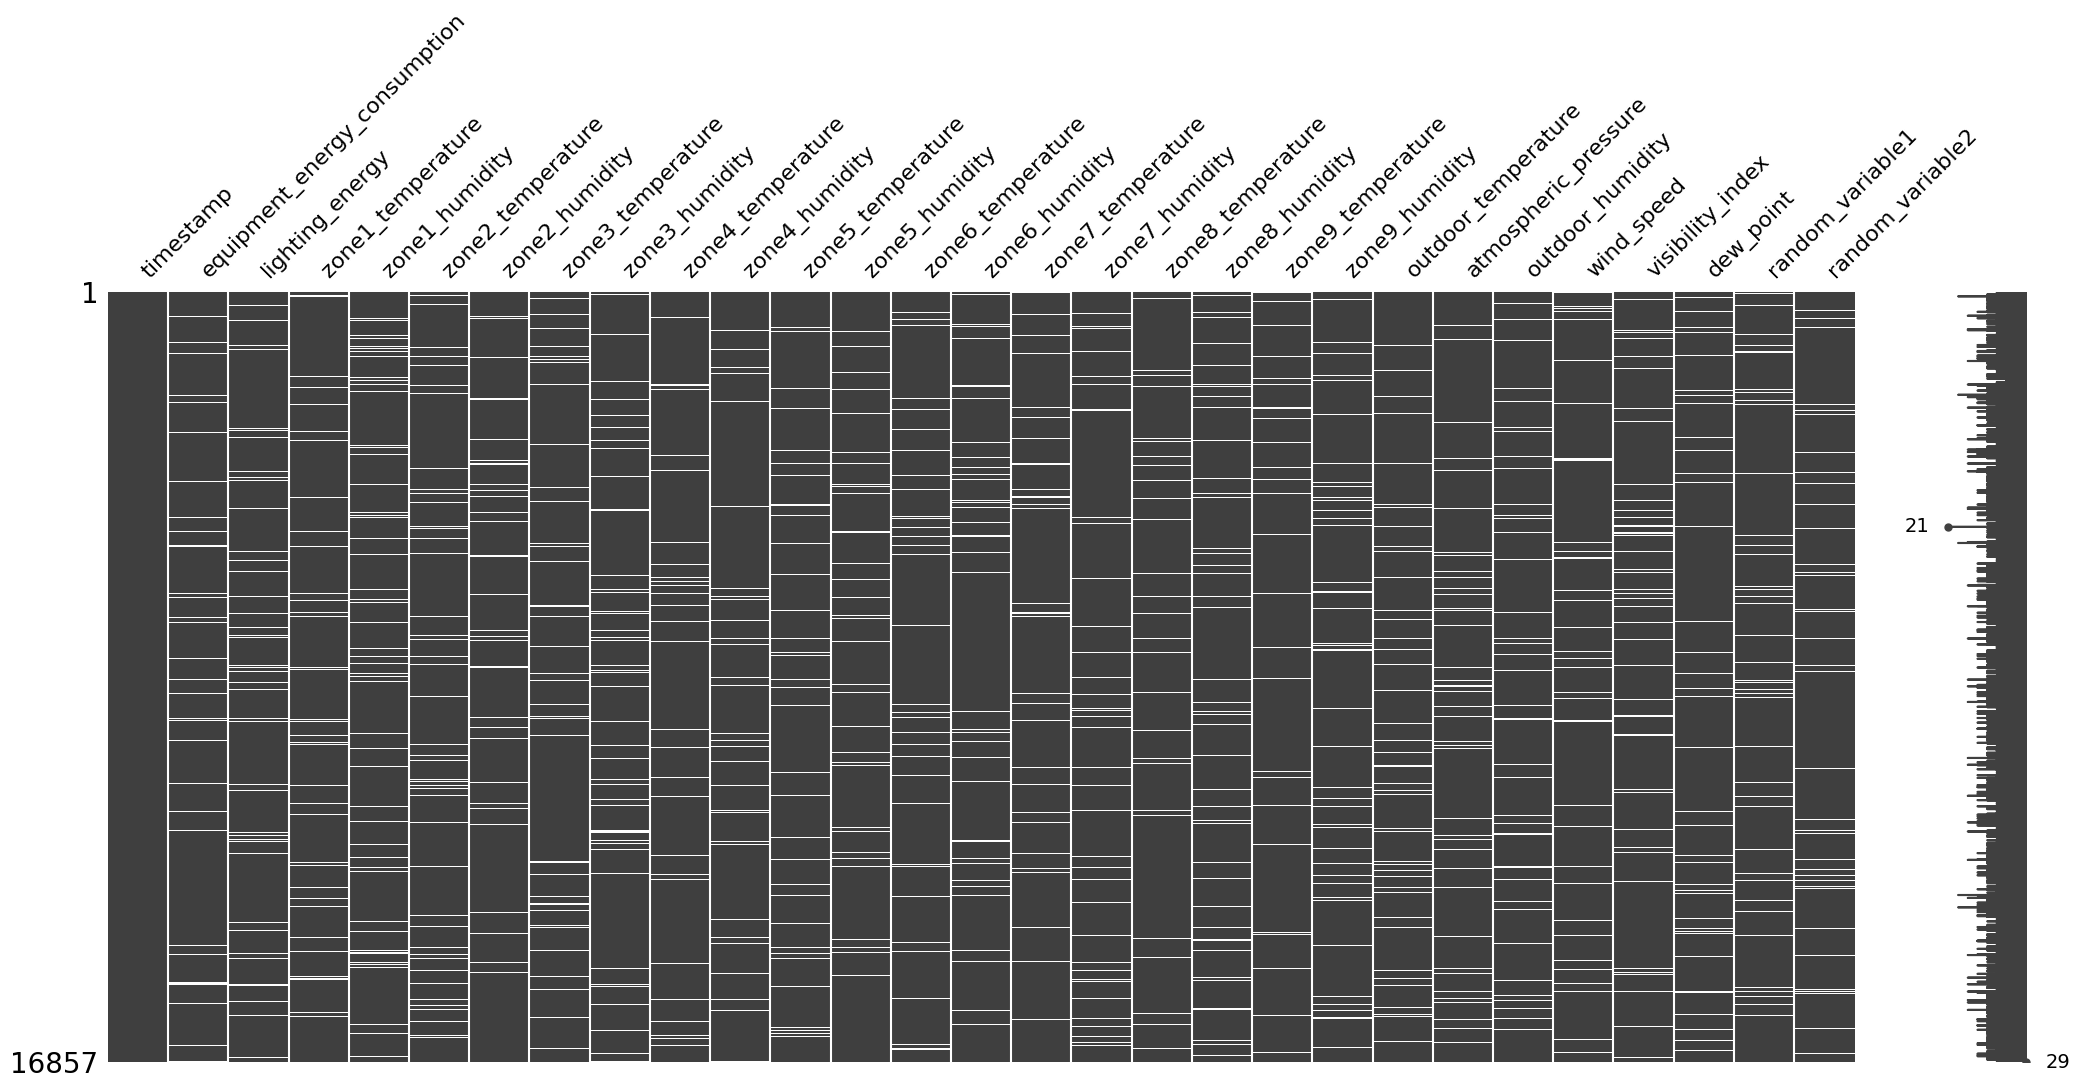

In [81]:
import missingno as msno

# Visualize missing values using a matrix
msno.matrix(df)

# Replace 'unknown' and 'error' values with NaN
df.replace(['unknown', 'error'], np.nan, inplace=True)

# Convert all columns to numeric values where possible
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Impute missing values using the mean (can choose median or mode if needed)
df_imputed = df_numeric.fillna(df_numeric.mean())

# Now you have df_imputed, which contains the final cleaned data


b) Feature Engineering: Polynomial Features
Create polynomial features for selected columns.

In [83]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np

# Replace problematic string values with NaN
df[['zone1_temperature', 'zone1_humidity']] = df[['zone1_temperature', 'zone1_humidity']].replace(['check', 'error', 'unknown'], np.nan)

# Convert the columns to numeric (coerce forces strings to NaN)
df[['zone1_temperature', 'zone1_humidity']] = df[['zone1_temperature', 'zone1_humidity']].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaNs in these two columns (or you can fill them if preferred)
df = df.dropna(subset=['zone1_temperature', 'zone1_humidity'])

# Apply PolynomialFeatures
poly_input = df[['zone1_temperature', 'zone1_humidity']]
poly = PolynomialFeatures(degree=2, include_bias=False)
df_poly = poly.fit_transform(poly_input)

# Get the polynomial feature names
poly_columns = poly.get_feature_names_out(['zone1_temperature', 'zone1_humidity'])

# Convert the result to a DataFrame
df_poly = pd.DataFrame(df_poly, columns=poly_columns, index=df.index)

# Concatenate polynomial features with original DataFrame
df = pd.concat([df, df_poly], axis=1)

# Display the updated DataFrame
print(df.head())


             timestamp equipment_energy_consumption     lighting_energy  \
0  2016-01-11 17:00:00                         60.0  -77.78778596503064   
1  2016-01-11 17:10:00                         60.0                30.0   
2  2016-01-11 17:20:00                         50.0                30.0   
3  2016-01-11 17:30:00                         50.0                40.0   
4  2016-01-11 17:40:00                         60.0                40.0   

   zone1_temperature  zone1_humidity zone2_temperature  zone2_humidity  \
0          33.746609       47.596667              19.2       44.790000   
1          19.890000       46.693333              19.2       44.722500   
2          19.890000       46.300000              19.2       44.626667   
3          33.746609       46.066667              19.2       44.590000   
4          19.890000       46.333333              19.2       44.530000   

   zone3_temperature  zone3_humidity  zone4_temperature  ...  wind_speed  \
0              19.79        

5. Handle Timestamps and Additional Preprocessing
a) Handling Timestamps (if applicable)

# Convert the timestamp column to datetime and extract useful features like hour, day, & month.

In [86]:
# Check if 'timestamp' column exists
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df.drop('timestamp', axis=1, inplace=True)
else:
    print("The 'timestamp' column is not present in the dataset.")


The 'timestamp' column is not present in the dataset.


b) Handling Non-Numeric Values
Replace problematic string values with NaN, then convert to numeric.

In [189]:
# Replace known non-numeric placeholders with NaN
df.replace(['???', 'unknown', 'error', 'check'], np.nan, inplace=True)

# Attempt to convert all columns to numeric where possible
df_cleaned = df.apply(pd.to_numeric, errors='coerce')

# Optional: Fill or drop missing values (depending on your strategy)
df_cleaned = df_cleaned.fillna(df_cleaned.mean())  # or df_cleaned.dropna()

6. Data Visualization: Correlation Heatmaps
a) Correlation Heatmap

# Visualize the correlation matrix to explore relationships between features and the target

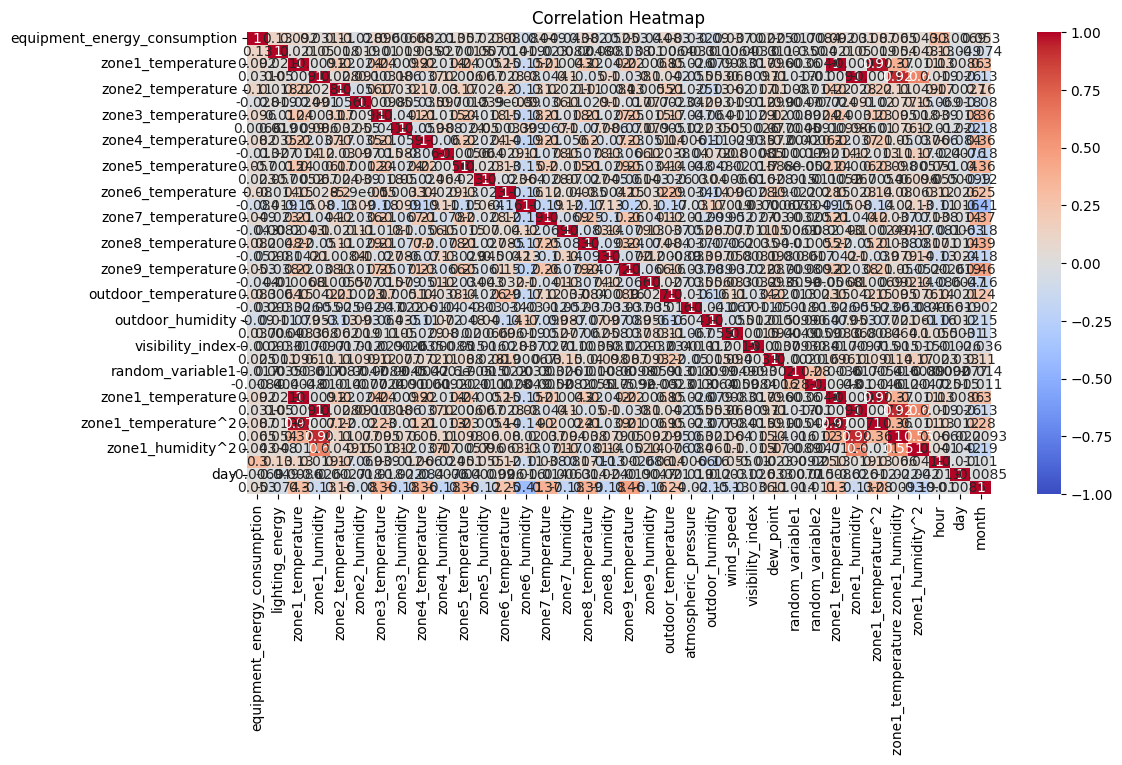

In [190]:
# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

b) Top Correlated Features

# Focus on features most correlated with energy consumption.

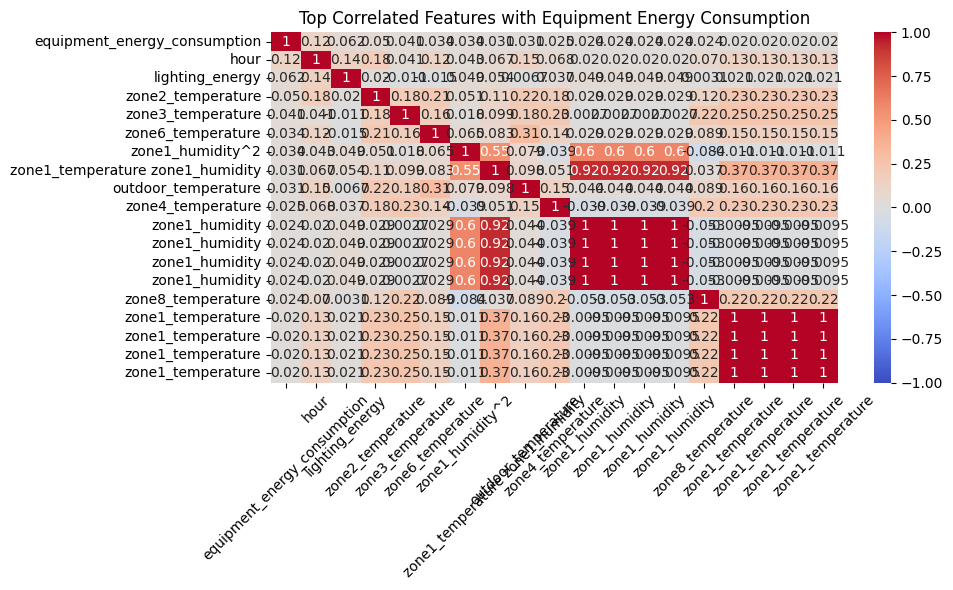

In [90]:
# Correlation with target only
target_corr = df.corr()['equipment_energy_consumption'].sort_values(ascending=False)

# Plot top 15 correlated features
plt.figure(figsize=(10, 6))
sns.heatmap(df[target_corr.index[:15]].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top Correlated Features with Equipment Energy Consumption')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


7. Data Scaling (if needed)
 Standard Scaling

# Apply standard scaling to the data (if needed).

In [92]:
# Example of Standard Scaling (only if needed)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


In [94]:
# Convert 'equipment_energy_consumption' to numeric, forcing errors to NaN
df['equipment_energy_consumption'] = pd.to_numeric(df['equipment_energy_consumption'], errors='coerce')

# Optional: Check skewness again
print("Skewness before log1p:", df['equipment_energy_consumption'].skew())

# Drop or fill NaN values before applying log1p
df['equipment_energy_consumption'].fillna(df['equipment_energy_consumption'].mean(), inplace=True)

# Apply log1p transformation
df['equipment_energy_consumption'] = np.log1p(df['equipment_energy_consumption'])

# Check skewness after log transform
print("Skewness after log1p:", df['equipment_energy_consumption'].skew())


Skewness before log1p: 0.5995580201568699
Skewness after log1p: 1.344657120143875


C:\Users\USER\AppData\Local\Temp\ipykernel_14316\786778079.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['equipment_energy_consumption'].fillna(df['equipment_energy_consumption'].mean(), inplace=True)
c:\Users\USER\Downloads\DS-Intern-Assignment-SuryaprakashYadav-main\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


8. Feature and Target Separation
 Define Features and Target

# Separate the features (X) and target (y).

In [96]:
# Define features (X) and target (y)
X = df.drop('equipment_energy_consumption', axis=1)
y = df['equipment_energy_consumption']

9. Train-Test Split
 Split the Data into Training and Testing Sets

# We split the data into training and testing sets (80% train, 20% test)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [97]:
# Check the column names of the DataFrame
print(df.columns)


Index(['equipment_energy_consumption', 'lighting_energy', 'zone1_temperature',
       'zone1_humidity', 'zone2_temperature', 'zone2_humidity',
       'zone3_temperature', 'zone3_humidity', 'zone4_temperature',
       'zone4_humidity', 'zone5_temperature', 'zone5_humidity',
       'zone6_temperature', 'zone6_humidity', 'zone7_temperature',
       'zone7_humidity', 'zone8_temperature', 'zone8_humidity',
       'zone9_temperature', 'zone9_humidity', 'outdoor_temperature',
       'atmospheric_pressure', 'outdoor_humidity', 'wind_speed',
       'visibility_index', 'dew_point', 'random_variable1', 'random_variable2',
       'zone1_temperature', 'zone1_humidity', 'zone1_temperature^2',
       'zone1_temperature zone1_humidity', 'zone1_humidity^2', 'hour', 'day',
       'month'],
      dtype='object')


In [102]:
# Check for and ensure the target variable 'y_train' is free from missing (NaN) values before model training.

print(y_train.isna().sum())


222


In [103]:
# Remove rows with NaN values in y_train and ensure alignment between X_train and y_train by dropping corresponding rows.

y_train = y_train.dropna()


In [104]:
df = df.dropna(subset=['equipment_energy_consumption'])  # drop rows where target is NaN


In [105]:
# Convert 'equipment_energy_consumption' to numeric, coercing errors to NaN, and drop rows with NaN in the target column.

df['equipment_energy_consumption'] = pd.to_numeric(df['equipment_energy_consumption'], errors='coerce')
df = df.dropna(subset=['equipment_energy_consumption'])


C:\Users\USER\AppData\Local\Temp\ipykernel_14316\2227695745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['equipment_energy_consumption'] = pd.to_numeric(df['equipment_energy_consumption'], errors='coerce')


10. Model Selection and Tuning
 Hyperparameter Tuning with Random Search

# Performed a random search to find the best hyperparameters for the model.

In [108]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10)
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,  # Try only 10 combinations
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 142}


In [35]:
# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}


In [152]:
# Check and print the number of NaN values in both the target variable 'y_test' and the model predictions.

print("NaNs in y_test:", np.isnan(y_test).sum())
print("NaNs in predictions:", np.isnan(predictions).sum())


NaNs in y_test: 60
NaNs in predictions: 0


In [192]:
# Remove rows where y_test contains NaNs
nan_indices = np.isnan(y_test)
X_test_clean = X_test[~nan_indices]
y_test_clean = y_test[~nan_indices]

# Now, make predictions on the cleaned test set
predictions = best_model.predict(X_test_clean)


11. Model Evaluation
 Evaluation Metrics

# Evaluate the model using RMSE, MAE, and R2 score.

In [193]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_clean, predictions))
mae = mean_absolute_error(y_test_clean, predictions)
r2 = r2_score(y_test_clean, predictions)

# Display evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Root Mean Squared Error (RMSE): 0.5271
Mean Absolute Error (MAE): 0.3446
R² Score: 0.4505


In [165]:
# Check for NaN values in X_test and y_test (since they are NumPy arrays)
print(f"NaN values in X_test: {np.isnan(X_test).sum()}")
print(f"NaN values in y_test: {np.isnan(y_test).sum()}")


NaN values in X_test: 0
NaN values in y_test: 60


In [169]:
# Remove rows where any of the features in X_test have NaN values, and y_test also has NaN values
nan_indices_X = np.isnan(X_test).any(axis=1)
nan_indices_y = np.isnan(y_test)

# Clean the data
X_test_clean = X_test[~nan_indices_X]
y_test_clean = y_test[~nan_indices_y]

# Check again for NaN values
print(f"NaN values in cleaned X_test: {np.isnan(X_test_clean).sum()}")
print(f"NaN values in cleaned y_test: {np.isnan(y_test_clean).sum()}")


NaN values in cleaned X_test: 0
NaN values in cleaned y_test: 0


In [177]:
# Remove rows where y_test contains NaNs
nan_indices = np.isnan(y_test)
X_test_clean = X_test[~nan_indices]
y_test_clean = y_test[~nan_indices]

# Now, make predictions on the cleaned test set
xgb_predictions = xgb_model.predict(X_test_clean)

# Evaluate the XGBoost model
xgb_rmse = np.sqrt(mean_squared_error(y_test_clean, xgb_predictions))
xgb_mae = mean_absolute_error(y_test_clean, xgb_predictions)
xgb_r2 = r2_score(y_test_clean, xgb_predictions)

# Print the XGBoost evaluation metrics
print(f"XGBoost - RMSE: {xgb_rmse:.4f}, MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}")


XGBoost - RMSE: 0.5462, MAE: 0.3636, R²: 0.4100


In [184]:
# Check for NaN values in y_test_clean
print(f"NaN values in y_test_clean: {np.isnan(y_test_clean).sum()}")

# Check for NaN values in final_predictions
print(f"NaN values in final_predictions: {np.isnan(final_predictions).sum()}")

# If there are NaN values, handle them by removing the corresponding rows
if np.isnan(y_test_clean).any() or np.isnan(final_predictions).any():
    print("Cleaning NaN values...")
    # Remove NaN values from both y_test_clean and final_predictions
    valid_indices = ~np.isnan(y_test_clean) & ~np.isnan(final_predictions)
    y_test_clean = y_test_clean[valid_indices]
    final_predictions = final_predictions[valid_indices]

# Recalculate RMSE, MAE, and R² after cleaning NaN values
ensemble_rmse = np.sqrt(mean_squared_error(y_test_clean, final_predictions))
ensemble_mae = mean_absolute_error(y_test_clean, final_predictions)
ensemble_r2 = r2_score(y_test_clean, final_predictions)

# Print the Ensemble model evaluation metrics
print(f"Ensemble Model - RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")


NaN values in y_test_clean: 60
NaN values in final_predictions: 0
Cleaning NaN values...
Ensemble Model - RMSE: 0.5253, MAE: 0.3418, R²: 0.4542


12. Visualize Predictions
 Plot Actual vs Predicted Energy Consumption

# Visualize the actual vs predicted energy consumption.

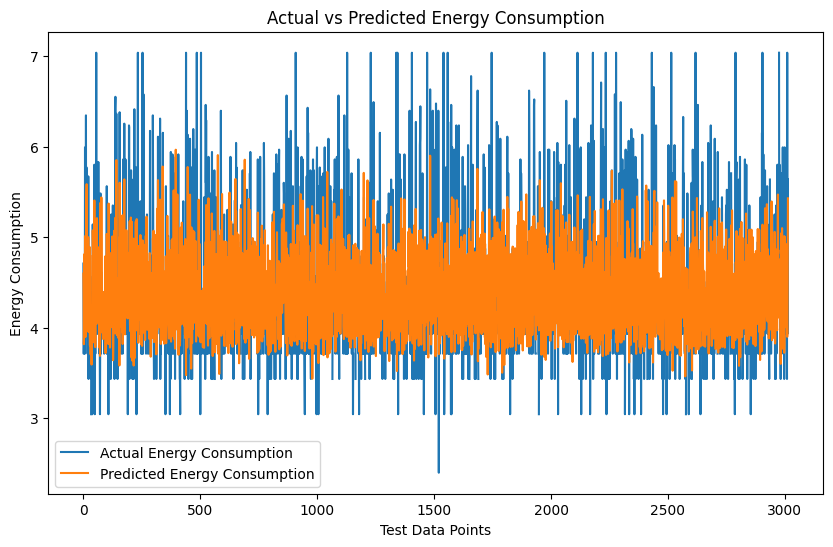

In [188]:
# Plotting actual vs predicted energy consumption
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Energy Consumption')
plt.plot(predictions, label='Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Test Data Points')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
